In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()

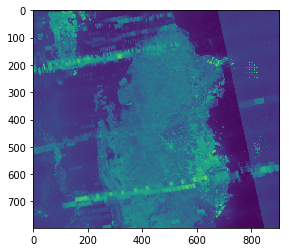

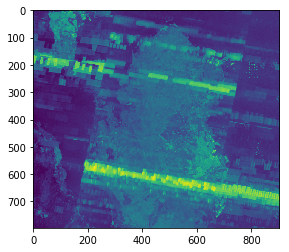

In [6]:
ds = gdal.Open('./vhExport.tif')

vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
plt.imshow(vh)
plt.show()

vv_band = ds.GetRasterBand(2)
vv = vv_band.ReadAsArray()
plt.imshow(vv)
plt.show()

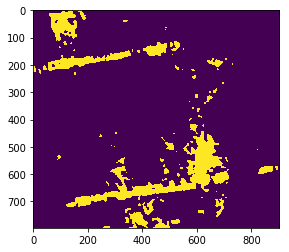

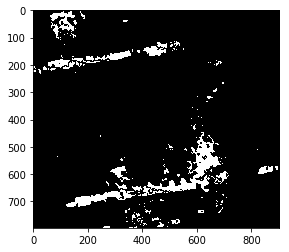

In [28]:
# Force VH data into something that OpenCV will work with
# (don't ask why its so big, I didn't write OpenCV)
vh_shifted = vh - np.min(vh)
vh_scaled = vh_shifted / np.max(vh_shifted) * 255
vh_scaled = np.array(vh_scaled, dtype=np.uint8)
img = np.zeros([vh.shape[0],vh.shape[1],3])
img[:,:,0] = vh_scaled
img[:,:,1] = vh_scaled
img[:,:,2] = vh_scaled
r,g,b = cv2.split(img)
img_bgr = cv2.merge([b,g,r])
img_bgr = img_bgr.astype('uint8')
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray,(10,10))

# Threshold to a binary image
(thresh, vh_im_bw) = cv2.threshold(gray, 110, 1, 0)
plt.imshow(vh_im_bw)
plt.show()

# Find contours in the binary image
im2, vh_contours, hierarchy = cv2.findContours(vh_im_bw, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(vh_im_bw, contours, -1, (0,255,0), 3)
plt.imshow(vh_im_bw,cmap='gray')
plt.show()

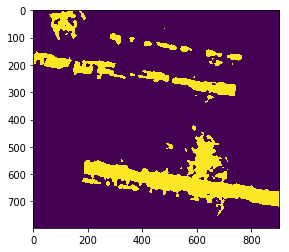

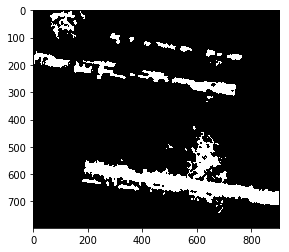

In [29]:
# Force vv data into something that OpenCV will work with
# (don't ask why its so big, I didn't write OpenCV)
vv_shifted = vv - np.min(vv)
vv_scaled = vv_shifted / np.max(vv_shifted) * 255
vv_scaled = np.array(vv_scaled, dtype=np.uint8)
img = np.zeros([vv.shape[0],vv.shape[1],3])
img[:,:,0] = vv_scaled
img[:,:,1] = vv_scaled
img[:,:,2] = vv_scaled
r,g,b = cv2.split(img)
img_bgr = cv2.merge([b,g,r])
img_bgr = img_bgr.astype('uint8')
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray,(10,10))

# Threshold to a binary image
(thresh, vv_im_bw) = cv2.threshold(gray, 110, 1, 0)
plt.imshow(vv_im_bw)
plt.show()

# Find contours in the binary image
im2, vv_contours, hierarchy = cv2.findContours(vv_im_bw, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(vv_im_bw, contours, -1, (0,255,0), 3)
plt.imshow(vv_im_bw,cmap='gray')
plt.show()

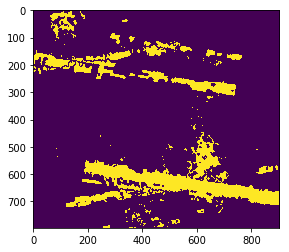

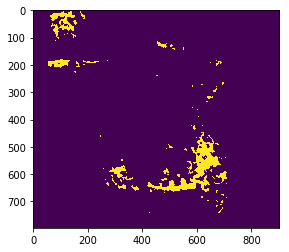

In [26]:
intersection = np.logical_and(vh_im_bw, vv_im_bw)
union = np.logical_or(vh_im_bw, vv_im_bw)

plt.imshow(union)
plt.show()

plt.imshow(intersection)
plt.show()